In [0]:
import cv2
import numpy as np
import math
from google.colab.patches import cv2_imshow

# import the necessary packages
import imutils
from google.colab.patches import cv2_imshow


def pyramid(image, scale=1.5, minSize=(30, 30)):
	# yield the original image
	yield image

  
	# keep looping over the pyramid
	while True:
		# compute the new dimensions of the image and resize it
		w = int(image.shape[1] / scale)
		image = imutils.resize(image, width=w)

		# if the resized image does not meet the supplied minimum
		# size, then stop constructing the pyramid
		if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
			break

		# yield the next image in the pyramid
		yield image

def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])


In [2]:
from google.colab import files
uploaded = files.upload()

Saving 01.jpg to 01.jpg


In [0]:
# USAGE
# python sliding_window.py --image images/adrian_florida.jpg 

# import the necessary packages

import argparse
import time
import cv2


# load the image and define the window width and height
orginal_image = cv2.imread('01.jpg')
(winW, winH) = (128, 128)

# loop over the image pyramid
for resized in pyramid(orginal_image, scale=1.5):
	# loop over the sliding window for each layer of the pyramid
	for (x, y, window) in sliding_window(resized, stepSize=32, windowSize=(winW, winH)):
		# if the window does not meet our desired window size, ignore it
		if window.shape[0] != winH or window.shape[1] != winW:
			continue

		# THIS IS WHERE YOU WOULD PROCESS YOUR WINDOW, SUCH AS APPLYING A
		# MACHINE LEARNING CLASSIFIER TO CLASSIFY THE CONTENTS OF THE
		# WINDOW

		# since we do not have a classifier, we'll just draw the window
clone = resized.copy()
cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
#cv2_imshow(clone)
cv2.waitKey(1)
time.sleep(0.025)


class ifChar:
    # this function contains some operations used by various function in the code
    def __init__(self, cntr):
        self.contour = cntr

        self.boundingRect = cv2.boundingRect(self.contour)

        [x, y, w, h] = self.boundingRect

        self.boundingRectX = x
        self.boundingRectY = y
        self.boundingRectWidth = w
        self.boundingRectHeight = h

        self.boundingRectArea = self.boundingRectWidth * self.boundingRectHeight

        self.centerX = (self.boundingRectX + self.boundingRectX + self.boundingRectWidth) / 2
        self.centerY = (self.boundingRectY + self.boundingRectY + self.boundingRectHeight) / 2

        self.diagonalSize = math.sqrt((self.boundingRectWidth ** 2) + (self.boundingRectHeight ** 2))

        self.aspectRatio =  float(self.boundingRectWidth) /  float(self.boundingRectHeight)

class PossiblePlate:

    def __init__(self):
        self.Plate = None
        self.Grayscale = None
        self.Thresh = None

        self.rrLocationOfPlateInScene = None

        self.strChars = ""


# this function is a 'first pass' that does a rough check on a contour to see if it could be a char
def checkIfChar(possibleChar):
    if (possibleChar.boundingRectArea > 80 and possibleChar.boundingRectWidth > 2
            and possibleChar.boundingRectHeight > 8 and 0.25 < possibleChar.aspectRatio < 1.0):

        return True
    else:
        return False


# check the center distance between characters
def distanceBetweenChars(firstChar, secondChar):
    x = abs(firstChar.centerX - secondChar.centerX)
    y = abs(firstChar.centerY - secondChar.centerY)
    z = math.sqrt((x ** 2) + (y ** 2))
    return z


# use basic trigonometry (SOH CAH TOA) to calculate angle between chars
def angleBetweenChars(firstChar, secondChar):
    adjacent =  float(abs(firstChar.centerX - secondChar.centerX))
    opposite =  float(abs(firstChar.centerY - secondChar.centerY))

    # check to make sure we do not divide by zero if the center X positions are equal
    # float division by zero will cause a crash in Python
    if adjacent != 0.0:
        angleInRad = math.atan(opposite / adjacent)
    else:
        angleInRad = 1.5708

    # calculate angle in degrees
    angleInDeg = angleInRad * (180.0 / math.pi)

    return angleInDeg


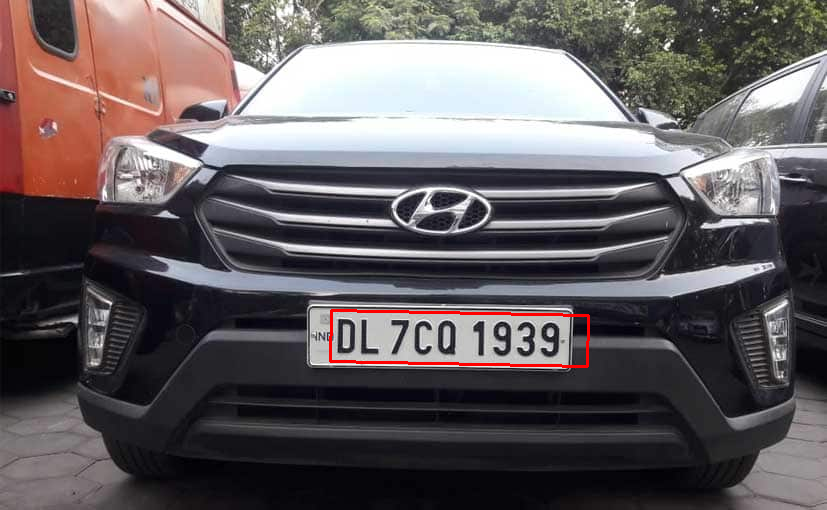

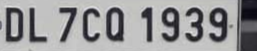

In [4]:

hsv = cv2.cvtColor(orginal_image, cv2.COLOR_BGR2HSV)
hue, saturation, value = cv2.split(hsv)


kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))


topHat = cv2.morphologyEx(value, cv2.MORPH_TOPHAT, kernel)
blackHat = cv2.morphologyEx(value, cv2.MORPH_BLACKHAT, kernel)


add = cv2.add(value, topHat)
subtract = cv2.subtract(add, blackHat)
cv2.imwrite('subtract.png', subtract)
blur = cv2.GaussianBlur(subtract, (5, 5), 0)
# cv2.imwrite(temp_folder + '6 - blur.png', blur)

# thresholding
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 9)
# cv2.imwrite(temp_folder + '7 - thresh.png', thresh)

# cv2.findCountours() function changed from OpenCV3 to OpenCV4: now it have only two parameters instead of 3
cv2MajorVersion = cv2.__version__.split(".")[0]
# check for contours on thresh
if int(cv2MajorVersion) >= 4:
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
else:
    imageContours, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

height, width = thresh.shape


imageContours = np.zeros((height, width, 3), dtype=np.uint8)

# list and counter of possible chars
possibleChars = []
countOfPossibleChars = 0

for i in range(0, len(contours)):

    # draw contours based on actual found contours of thresh image
    cv2.drawContours(imageContours, contours, i, (255, 255, 255))

    # retrieve a possible char by the result ifChar class give us
    possibleChar = ifChar(contours[i])

    # by computing some values (area, width, height, aspect ratio) possibleChars list is being populated
    if checkIfChar(possibleChar) is True:
        countOfPossibleChars = countOfPossibleChars + 1
        possibleChars.append(possibleChar)

# cv2.imwrite(temp_folder + '8 - imageContours.png', imageContours)

imageContours = np.zeros((height, width, 3), np.uint8)

ctrs = []

for char in possibleChars:
    ctrs.append(char.contour)

cv2.drawContours(imageContours, ctrs, -1, (255, 255, 255))
# cv2.imwrite(temp_folder + '9 - contoursPossibleChars.png', imageContours)

plates_list = []
listOfListsOfMatchingChars = []

for possibleC in possibleChars:

    def matchingChars(possibleC, possibleChars):
        listOfMatchingChars = []

        for possibleMatchingChar in possibleChars:
            if possibleMatchingChar == possibleC:
                continue

            # compute stuff to see if chars are a match
            distanceBetweenChars1 = distanceBetweenChars(possibleC, possibleMatchingChar)

            angleBetweenChars1 = angleBetweenChars(possibleC, possibleMatchingChar)

            changeInArea = float(abs(possibleMatchingChar.boundingRectArea - possibleC.boundingRectArea)) / float(
                possibleC.boundingRectArea)

            changeInWidth = float(abs(possibleMatchingChar.boundingRectWidth - possibleC.boundingRectWidth)) / float(
                possibleC.boundingRectWidth)

            changeInHeight = float(abs(possibleMatchingChar.boundingRectHeight - possibleC.boundingRectHeight)) / float(
                possibleC.boundingRectHeight)

            # check if chars match
            if distanceBetweenChars1 < (possibleC.diagonalSize * 5) and \
                    angleBetweenChars1 < 12.0 and \
                    changeInArea < 0.5 and \
                    changeInWidth < 0.8 and \
                    changeInHeight < 0.2:
                listOfMatchingChars.append(possibleMatchingChar)

        return listOfMatchingChars



    listOfMatchingChars = matchingChars(possibleC, possibleChars)

    listOfMatchingChars.append(possibleC)

    if len(listOfMatchingChars) < 3:
        continue

    # here the current list passed test as a "group" or "cluster" of matching chars
    listOfListsOfMatchingChars.append(listOfMatchingChars)


    listOfPossibleCharsWithCurrentMatchesRemoved = list(set(possibleChars) - set(listOfMatchingChars))

    recursiveListOfListsOfMatchingChars = []

    for recursiveListOfMatchingChars in recursiveListOfListsOfMatchingChars:
        listOfListsOfMatchingChars.append(recursiveListOfMatchingChars)

    break

imageContours = np.zeros((height, width, 3), np.uint8)

for listOfMatchingChars in listOfListsOfMatchingChars:
    contoursColor = (255, 0, 255)

    contours = []

    for matchingChar in listOfMatchingChars:
        contours.append(matchingChar.contour)

    cv2.drawContours(imageContours, contours, -1, contoursColor)



for listOfMatchingChars in listOfListsOfMatchingChars:
    possiblePlate = PossiblePlate()

    # sort chars from left to right based on x position
    listOfMatchingChars.sort(key=lambda matchingChar: matchingChar.centerX)

    # calculate the center point of the plate
    plateCenterX = (listOfMatchingChars[0].centerX + listOfMatchingChars[len(listOfMatchingChars) - 1].centerX) / 2.0
    plateCenterY = (listOfMatchingChars[0].centerY + listOfMatchingChars[len(listOfMatchingChars) - 1].centerY) / 2.0

    plateCenter = plateCenterX, plateCenterY

    # calculate plate width and height
    plateWidth = int((listOfMatchingChars[len(listOfMatchingChars) - 1].boundingRectX + listOfMatchingChars[
        len(listOfMatchingChars) - 1].boundingRectWidth - listOfMatchingChars[0].boundingRectX) * 1.3)

    totalOfCharHeights = 0

    for matchingChar in listOfMatchingChars:
        totalOfCharHeights = totalOfCharHeights + matchingChar.boundingRectHeight

    averageCharHeight = totalOfCharHeights / len(listOfMatchingChars)

    plateHeight = int(averageCharHeight * 1.5)

    # calculate correction angle of plate region
    opposite = listOfMatchingChars[len(listOfMatchingChars) - 1].centerY - listOfMatchingChars[0].centerY

    hypotenuse = distanceBetweenChars(listOfMatchingChars[0],
                                                listOfMatchingChars[len(listOfMatchingChars) - 1])
    correctionAngleInRad = math.asin(opposite / hypotenuse)
    correctionAngleInDeg = correctionAngleInRad * (180.0 / math.pi)

    # pack plate region center point, width and height, and correction angle into rotated rect member variable of plate
    possiblePlate.rrLocationOfPlateInScene = (tuple(plateCenter), (plateWidth, plateHeight), correctionAngleInDeg)

    # get the rotation matrix for our calculated correction angle
    rotationMatrix = cv2.getRotationMatrix2D(tuple(plateCenter), correctionAngleInDeg, 1.0)

    height, width, numChannels = orginal_image.shape

    # rotate the entire image
    imgRotated = cv2.warpAffine(orginal_image, rotationMatrix, (width, height))

    imgCropped = cv2.getRectSubPix(imgRotated, (plateWidth, plateHeight), tuple(plateCenter))

    # copy the cropped plate image into the applicable member variable of the possible plate
    possiblePlate.Plate = imgCropped

    # populate plates_list with the detected plate
    if possiblePlate.Plate is not None:
        plates_list.append(possiblePlate)

    # draw a ROI on the original image
    for i in range(0, len(plates_list)):
        p2fRectPoints = cv2.boxPoints(plates_list[i].rrLocationOfPlateInScene)

        # roi rectangle colour
        rectColour = (0, 0, 255)

        cv2.line(imageContours, tuple(p2fRectPoints[0]), tuple(p2fRectPoints[1]), rectColour, 2)
        cv2.line(imageContours, tuple(p2fRectPoints[1]), tuple(p2fRectPoints[2]), rectColour, 2)
        cv2.line(imageContours, tuple(p2fRectPoints[2]), tuple(p2fRectPoints[3]), rectColour, 2)
        cv2.line(imageContours, tuple(p2fRectPoints[3]), tuple(p2fRectPoints[0]), rectColour, 2)

        cv2.line(orginal_image, tuple(p2fRectPoints[0]), tuple(p2fRectPoints[1]), rectColour, 2)
        cv2.line(orginal_image, tuple(p2fRectPoints[1]), tuple(p2fRectPoints[2]), rectColour, 2)
        cv2.line(orginal_image, tuple(p2fRectPoints[2]), tuple(p2fRectPoints[3]), rectColour, 2)
        cv2.line(orginal_image, tuple(p2fRectPoints[3]), tuple(p2fRectPoints[0]), rectColour, 2)
        from google.colab.patches import cv2_imshow
        cv2.imwrite( 'detectedplate.png', plates_list[i].Plate)
        cv2_imshow(orginal_image)
        print("\n")
        cv2_imshow(plates_list[i].Plate)
